**Framing the problem and looking at the big picture:**

The goal of this machine learning project is to be able to predict whether an individual will make a purchase based on their age and their estimated salary. This is an especially useful application for stores that want to:

*   Identify people who are likely to buy a product so that they can focus on retaining them as loyal customers
*   Identify people who are not likely to buy a product so that they can go after them and try to convince them

In either case, being able to distinguish between the classes allows for more helpful decision making.

To accomplish this, we will train 5 different models. The first two will be simple SVC models (Support Vector Machines for classification), but one will be using LinearSVC and the other will be using SVC with a linear kernel. Afterwards, we will train an SGD model (Stochastic Gradient Descent) with a hinge loss function. Finally, we will train two additional models based on SVC, but using a non-linear kernel this time (rbf). The second one of these models will be trained after performing a randomized grid search to find the optimal parameters.



---

**Loading the data**

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [174]:
df = pd.read_csv('SocialAds.csv')

In [175]:
df.head()

,Age,EstimatedSalary,Purchased
0,19.0,19000.0,0
1,35.0,20000.0,0
2,26.0,43000.0,0
3,27.0,57000.0,0
4,19.0,76000.0,0


In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              398 non-null    float64
 1   EstimatedSalary  396 non-null    float64
 2   Purchased        400 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 9.5 KB


---
**Discovering and visualizing the data to gain insights**





In [177]:
df.describe()

,Age,EstimatedSalary,Purchased
count,398.000000,396.00000,400.000000
mean,37.658291,69969.69697,0.357500
std,10.480103,34112.23606,0.479864
min,18.000000,15000.00000,0.000000
25%,30.000000,43000.00000,0.000000
50%,37.000000,70000.00000,0.000000
75%,46.000000,88000.00000,1.000000
max,60.000000,150000.00000,1.000000


- some missing values
- there might be some outliers for EstimatedSalary (due to a large stdev), but until we plot the distribution we can't know for certain
- We will need to scale the attributes

Let's look at the distribution for the class we want to predict (purchased)

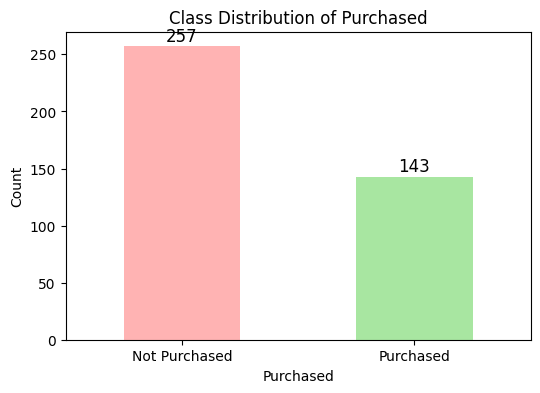

In [178]:
plt.figure(figsize=(6, 4))
df['Purchased'].value_counts().plot(kind='bar', color=['#FFB3B3', '#A8E6A1'])
plt.title('Class Distribution of Purchased')
plt.xlabel('Purchased')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Purchased', 'Purchased'], rotation=0)
for i, count in enumerate(df['Purchased'].value_counts()):
    plt.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=12)
plt.show()

We notice that the classes in our dataset are not balanced: we have 253 instances of not-purchased and only 141 instances of purchased. This may  affect how well our models are able to recognize purchased labels compared to not-purchased. Let's plot the two numerical variables:

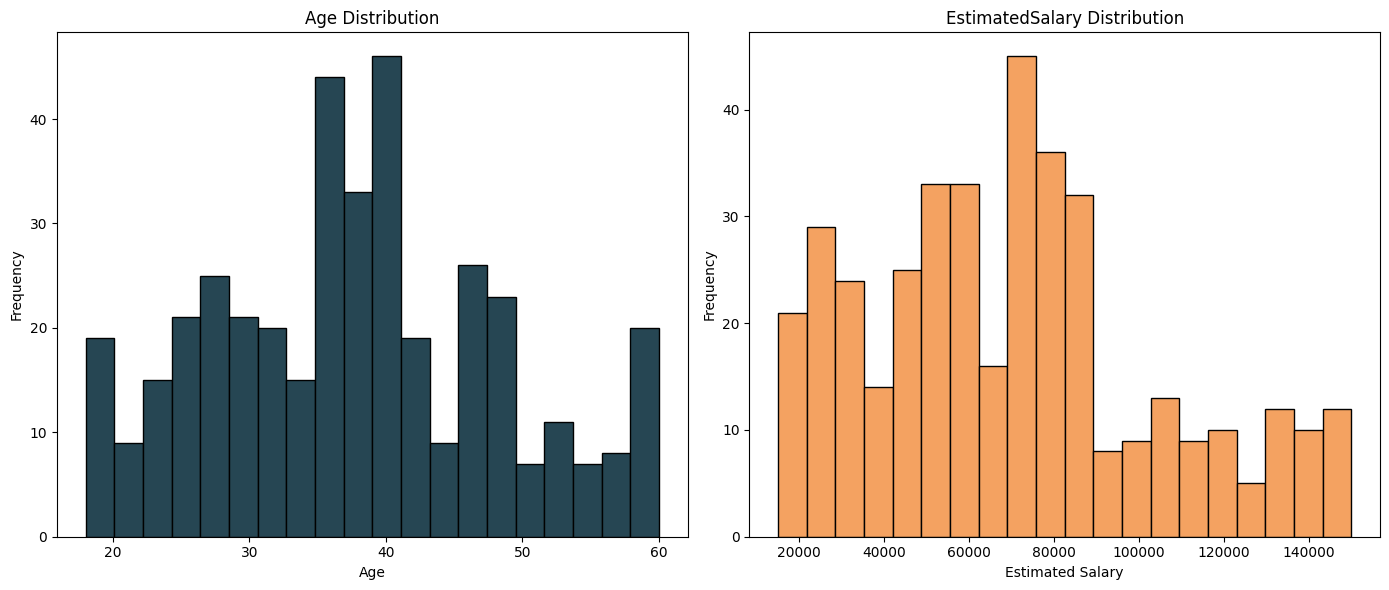

In [179]:
plt.figure(figsize=(14, 6))

# Age distribution
plt.subplot(1, 2, 1)
plt.hist(df['Age'], bins=20, color='#264653', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
# EstimatedSalary distribution
plt.subplot(1, 2, 2)
plt.hist(df['EstimatedSalary'], bins=20, color='#f4a261', edgecolor='black')
plt.title('EstimatedSalary Distribution')
plt.xlabel('Estimated Salary')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Since we will be training SVC models and we only have 2 features (age and salary), let's create a scatterplot for them to see if we can intuitively make out any boundaries. We will achieve this by highlighting the positive instances in our dataset (purchased=1) as green, and the negative instances (purchased=0) as red.

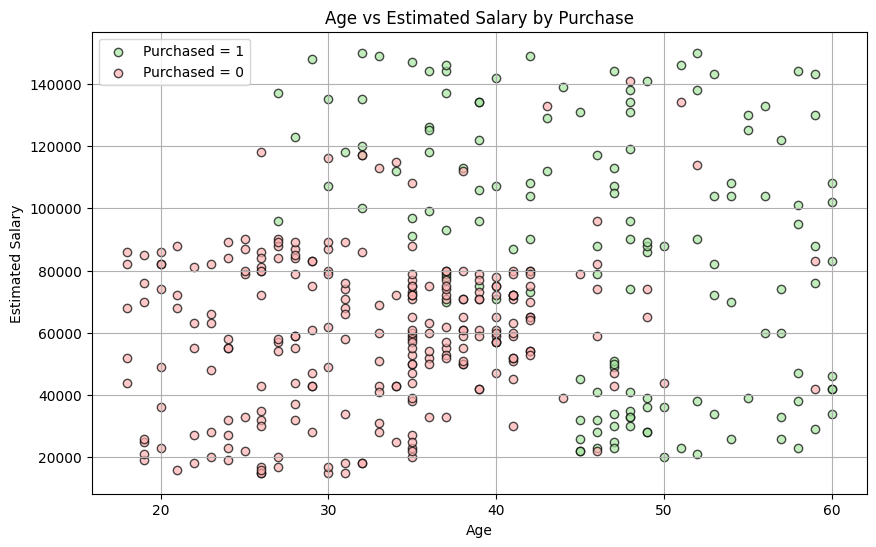

In [180]:
plt.figure(figsize=(10, 6))

# Plot points where Purchased = 1 (green)
plt.scatter(df[df['Purchased'] == 1]['Age'], df[df['Purchased'] == 1]['EstimatedSalary'],
            color='#A8E6A1', edgecolors='black', alpha=0.7, label='Purchased = 1')
# Plot points where Purchased = 0 (red)
plt.scatter(df[df['Purchased'] == 0]['Age'], df[df['Purchased'] == 0]['EstimatedSalary'],
            color='#FFB3B3', edgecolors='black', alpha=0.7, label='Purchased = 0')
plt.title('Age vs Estimated Salary by Purchase')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()

plt.grid(True)
plt.show()

It looks like our data can be separated using SVC models, however probably not using a linear kernel. A linear kernel would mean that the positive and negative classes can be separated with a line, but here we observe that this is unlikely. We also notice some overlap between classes, which means our model will most likely not be perfect.

Next, before we split our dataset into a train and test one, let's remove the missing values. From df.describe() above, we saw that out of 400 total observations, EstimatedSalary had the most missing values with 4, followed by Age with 2. This means that if we dropped all rows with missing values, we will at most drop 6 total rows out of 400, which isn't too many. Thus, we will drop these rows to deal with these missing values.

In [181]:
df = df.dropna()
print(f"DataFrame shape after removing missing values: {df.shape}")

DataFrame shape after removing missing values: (394, 3)


Let's split our data into a train and test set now:

In [182]:
# Creating the test set
from sklearn.model_selection import train_test_split
# We split the dataframe into a 20% test set and a 80% train set.
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
print('Lenght of train_set:', len(train_set), '\nLenght of test_set:', len(test_set))

Lenght of train_set: 315 
Lenght of test_set: 79


We just split our dataset into a train and test set. For now we will leave the test set alone and only use the train set.

In [183]:
socialAds = train_set.copy()

Let's look at how the variables are correlated in our train set (omitting our target variable 'Purchased') :

In [184]:
corr_matrix_socialAds = socialAds.drop('Purchased', axis=1).corr()
print("Correlation Matrix (without 'Purchased'):\n", corr_matrix_socialAds)

Correlation Matrix (without 'Purchased'):
                      Age  EstimatedSalary
Age              1.00000          0.19962
EstimatedSalary  0.19962          1.00000


We notice that the 2 features in our dataset have a very weak, if not negligible correlation due to their coefficient being so small. This is a good thing because it ensures each feature provides unique information to the model.



---
**Preparing the data for ML algorithms**


First, let's separate our train set (socialAds) into X_train and y_train:

In [185]:
# Separating the labels and the predictors:
X_train = socialAds.drop("Purchased", axis=1) # removing the labels from the training set
y_train = socialAds['Purchased'].copy() #storing the labels into a new variable

Next, since we will be training SVM models and these are sensitive to outliers, we'll create a pipeline that is fitted to our train data and transforms it into scaled features.

In [186]:
pipeline = Pipeline([
    ('scaler', StandardScaler())  # Apply standard scaling to the features
])
X_train_scaled = pipeline.fit_transform(X_train) # Fitting on the train set features and then transforming
print('First 10 instances after train set feature scaling:\n', X_train_scaled[:10])

First 10 instances after train set feature scaling:
 [[-0.18842694 -0.48904389]
 [-0.28249111  0.03463484]
 [-1.31719691 -1.39093504]
 [-0.65874776 -0.08173821]
 [ 0.09376555  0.18010115]
 [ 0.75221469  0.23828768]
 [ 0.94034302 -1.04181589]
 [ 0.84627886 -1.07090915]
 [-0.28249111 -0.45995063]
 [-0.18842694  1.60567103]]




---
**Select and train a model**



For all models, we will evaluate them using two different methods, both computed after doing 5-fold cross validation on the train set:

*   Accuracy scores
*   Recall and precision scores (including the confusion matrix)


In SVM, and more precisely for SVC, we want to separate the classes while trying to maximize the margin between them (the 'street'). This is because a larger margin indicates that the decision boundary is further away from the closest points of each class, which generally leads to better generalization and less overfitting.



For our first model, we will use linearSVC with C=1 and the hinge loss function.
The loss = hinge parameter is a parameter that penalizes points that are either misclassified or not classified with enough confidence (ex: points that are too close to the decision boundary)

The parameter C controls the strenght the regularization:

*   a smaller C value translates to more regularization, which means the model will care more about maximizing the margins instead of correctly classifying observations
*   a larger C value means the model focuses more on correctly classifying observations (by minimizing the hinge loss function), which might result into smaller margins and more overfitting



In [187]:
from sklearn.svm import LinearSVC
linearSVC = LinearSVC(C=1, loss="hinge")
linearSVC.fit(X_train_scaled, y_train)

LinearSVC(C=1, loss='hinge')

In [188]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [189]:
# Doing 5-fold cross-validation for the linearSVC1 model
cv_scores_1 = cross_val_score(linearSVC, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracies: {cv_scores_1}")
print(f"Mean cross-validation accuracy: {np.mean(cv_scores_1):.4f}")
print(f"Standard deviation: {np.std(cv_scores_1):.4f}")

Cross-validation accuracies: [0.80952381 0.85714286 0.92063492 0.85714286 0.77777778]
Mean cross-validation accuracy: 0.8444
Standard deviation: 0.0486


In [190]:
cv_predictions_1 = cross_val_predict(linearSVC, X_train_scaled, y_train, cv=5)
precision = precision_score(y_train, cv_predictions_1)
recall = recall_score(y_train, cv_predictions_1)
cm = confusion_matrix(y_train, cv_predictions_1)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("\nConfusion Matrix:\n", cm)

Precision: 0.8617
Recall: 0.6923

Confusion Matrix:
 [[185  13]
 [ 36  81]]



Accuracy tells us what proportion of the total classifications our model got correct. This can be useful in providing us with a general idea on how the model performs, but it doesn't represent the whole picture. For example, a model could have an accuracy of 80% but be mostly suceeding in correctly identifying negative instances. Due to this, we should also analyze how well each of our models perform in terms of correctly identifying our positive class (purchased). One way we can achieve this is by computing precision and recall scores.

For this dataset, our target variable is "Purchased" with a value of 0 meaning the individual has not bought the product (negative class) and a value of 1 meaning the individual has bought the product (positive class).

Here, precision represents the portion of **predicted** purchased instances (positive) that the model correctly predicted. Meanwhile, recall represents the proportion of purchased instances that our model was able to identify out of all of the true purchased instances in the train set.

For our linearSVC model, after performing 5-fold cross validation on the train set, we obtain a mean accuracy of 0.84, a precision of 0.86 and a recall of 0.69.
This means that on average:

*   Accuracy: our model correctly predicts an instance ('purchased' or not) 84% of the time
*   Precision: when our model identified a 'purchased' instance, it got it right 86% of the time
*   Recall: Out of all 'purchased' instances in the training set, our model was able to identify 69% of them.

We can further confirm these findings by taking a look at the confusion matrix. We notice that our model correctly identified 185 purchased instances and 81 non-purchased instances. However, we also see that it **incorrectly** predicted 36 instances as non-purchased, and **incorrectly** predicted 13 instances as purchased.

These results seem alright, but there is clear room for improvement (whether through parameter tuning or using another kernel).
For now, let's train an SVC model using SVC(kernel='linear') instead of LinearSVC. We will use C = 1 since we also used the same value for the LinearSVC model.

In [191]:
from sklearn.svm import SVC
SVC1 = SVC(kernel='linear', C=1)
SVC1.fit(X_train_scaled, y_train)

SVC(C=1, kernel='linear')

In [192]:
cv_scores_2 = cross_val_score(SVC1, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracies: {cv_scores_2}")
print(f"Mean cross-validation accuracy: {np.mean(cv_scores_2):.4f}")
print(f"Standard deviation: {np.std(cv_scores_2):.4f}")
cv_predictions_2 = cross_val_predict(SVC1, X_train_scaled, y_train, cv=5)
precision = precision_score(y_train, cv_predictions_2)
recall = recall_score(y_train, cv_predictions_2)
print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
cm = confusion_matrix(y_train, cv_predictions_2)
print("\nConfusion Matrix:\n", cm)

Cross-validation accuracies: [0.80952381 0.85714286 0.92063492 0.84126984 0.77777778]
Mean cross-validation accuracy: 0.8413
Standard deviation: 0.0481

Precision: 0.8602
Recall: 0.6838

Confusion Matrix:
 [[185  13]
 [ 37  80]]


In terms of accuracy, precision and recall we obtain very similar scores. Instead of comparing the scores, we can look at the confusion matrix for both models instead.
We notice that for both linearSVC and SVC(kernel='linear'), the models correctly identified the same amount of purchased (positive) instances (185). However, the linearSVC model correctly identified **1** additional non-purchased instance (81) compared to the SVC(kernel='linear') model (80).

Since the difference is so small, we cannot be certain that one model performs better than the other, also these results were obtained after doing cross-validation on our train set. However, it is important to mention that LinearSVC is faster performing than SVC, but SVC allows for different kernels (non-linear) to be used.

Next, let's train a stochastic gradient descent (SGD) classifier with the parameter loss = 'hinge', like we did for the LinearSVC model. For SGD, it is the parameter 'alpha' that represents the strenght of the regularization (smaller value = weaker regularization = can lead to overfitting and other way around). We will also use the default value for learning rate which is 'optimal'.

Afterwards we will compare the models and see if there are any significant differences.

In [193]:
from sklearn.linear_model import SGDClassifier
SGD = SGDClassifier(loss='hinge', alpha=0.001, learning_rate='optimal', random_state=42)
SGD.fit(X_train_scaled, y_train)

SGDClassifier(alpha=0.001, random_state=42)

In [194]:
cv_scores_3 = cross_val_score(SGD, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracies: {cv_scores_3}")
print(f"Mean cross-validation accuracy: {np.mean(cv_scores_3):.4f}")
print(f"Standard deviation: {np.std(cv_scores_3):.4f}")
cv_predictions_3 = cross_val_predict(SGD, X_train_scaled, y_train, cv=5)
precision = precision_score(y_train, cv_predictions_3)
recall = recall_score(y_train, cv_predictions_3)
print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
cm = confusion_matrix(y_train, cv_predictions_3)
print("\nConfusion Matrix:\n", cm)

Cross-validation accuracies: [0.82539683 0.87301587 0.9047619  0.85714286 0.77777778]
Mean cross-validation accuracy: 0.8476
Standard deviation: 0.0433

Precision: 0.8485
Recall: 0.7179

Confusion Matrix:
 [[183  15]
 [ 33  84]]


We notice that when we compare the SGD model to the two previous models, it has a similar accuracy, slightly lower precision but slightly higher recall score.

Thus, the SGD model was able to correctly identify more non-purchased (negative) instances than the previous two models (84 compared to 80 and 81) but it also correctly identified less purchased (positive) instances (183 compared to 185 for both previous models).

Next, let's train an SVC model by using another classifier (not linear). As we observed above, it is possible (and likely) that our data is not linearly separable. Because of this, we'll train an SVC model using the rbf (Gaussian Radial Basis Function) kernel instead.

Depending on the situation, we might want to prioritize precision or recall. Prioritizing precision would mean focusing more on predicting clients that will purchase an item, whereas prioritizing recall would mean focusing more on predicting clients that will not purchase anything.

In [195]:
from sklearn.svm import SVC
svm_clf = SVC(kernel='rbf', random_state=0)
svm_clf.fit(X_train_scaled, y_train)

SVC(random_state=0)

In [196]:
cv_scores_4 = cross_val_score(svm_clf, X_train_scaled, y_train, cv=5, scoring='accuracy')
cv_predictions_4 = cross_val_predict(svm_clf, X_train_scaled, y_train, cv=5)
precision = precision_score(y_train, cv_predictions_4)
recall = recall_score(y_train, cv_predictions_4)
cm = confusion_matrix(y_train, cv_predictions_4)
print(f"Cross-validation accuracies: {cv_scores_4}")
print(f"Mean cross-validation accuracy: {np.mean(cv_scores_4):.4f}")
print(f"Standard deviation: {np.std(cv_scores_4):.4f}")
print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("\nConfusion Matrix:\n", cm)

Cross-validation accuracies: [0.95238095 0.88888889 0.95238095 0.87301587 0.9047619 ]
Mean cross-validation accuracy: 0.9143
Standard deviation: 0.0327

Precision: 0.8571
Recall: 0.9231

Confusion Matrix:
 [[180  18]
 [  9 108]]


When comparing the non-linear SVC model to the previous 3 models, we immediately notice a much higher recall (0.92 compared to 0.71!). Furthermore, we also notice a small increase in the mean accuracy. Finally, the precision score remains similar to the previous three models, but maybe slightly lower than the two linear SVC models.

By using an rbf kernel instead of a linear one, we managed to significantly increase the number of negative instances that our model can correctly identify, which allows us to better distinguish between customers that will purchase things and those that won't.

This also confirms the original assumption we made after plotting the two features that they are not linearly separable.   

Out of all four models we created, the SVC model with the rbf kernel performed the best. Now, let's see if we can find the best parameters for this model using a randomized grid search. We will be performing randomized grid search for both C and gamma parameters using 1000 iterations (1000 random combinations of parameters) and cv = 5. For C, we will be sampling uniformely between 1 and 10 exclusive using uniform(1, 10), and for gamma we will be sampling between 0.001 and 0.1 using reciprocal(0.001, 0.1).

In [197]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
param_distributions = {'gamma': reciprocal(0.001, 0.1), 'C': uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=1000, verbose=1, cv=5, random_state=42)
rnd_search_cv.fit(X_train_scaled, y_train)
print(f"Best parameters: {rnd_search_cv.best_params_}")

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best parameters: {'C': 9.359801205122059, 'gamma': 0.024657464253392724}


We obtain a value for C of 9.359801205122059 and a value for gamma of 0.024657464253392724

Let's now define a new model called best_model which takes these parameters, and evaluate it on the training set.

In [198]:
best_model = rnd_search_cv.best_estimator_

In [199]:
cv_scores5 = cross_val_score(best_model, X_train_scaled, y_train, cv=3, scoring='accuracy')
cv_predictions_5 = cross_val_predict(best_model, X_train_scaled, y_train, cv=5)
precision = precision_score(y_train, cv_predictions_5)
recall = recall_score(y_train, cv_predictions_5)
cm = confusion_matrix(y_train, cv_predictions_5)
print(f"Cross-validation accuracies: {cv_scores5}")
print(f"Mean cross-validation accuracy: {np.mean(cv_scores5):.4f}")
print(f"Standard deviation: {np.std(cv_scores5):.4f}")
print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("\nConfusion Matrix:\n", cm)

Cross-validation accuracies: [0.91428571 0.8952381  0.87619048]
Mean cross-validation accuracy: 0.8952
Standard deviation: 0.0156

Precision: 0.8938
Recall: 0.8632

Confusion Matrix:
 [[186  12]
 [ 16 101]]


We notice that compared to the base rbf SVC model, this one as slightly lower accuracy, slightly higher precision but lower recall (101 TN vs 108 prev.). In total, the previous rbf model correctly predicted 288 instances whereas this one correctly predicted 287. It seems that maybe this model is overfitting the data and favoring the most common class (not purchased = 0). Because of this, we will go back to the base rbf model and use it on our testing set for evaluation.



---

**Fine tuning and evaluating the models to find the best one so that we can test it on the test dataset**

In [200]:
best_model = svm_clf

In [201]:
X_test = test_set.drop("Purchased", axis=1)
y_test = test_set['Purchased'].copy()
X_test_scaled = pipeline.transform(X_test) # not fit_transform()

In [202]:
# Making predictions on the scaled test set
y_pred = best_model.predict(X_test_scaled)

In [203]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall: {recall:.2f}")
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.90
Precision: 0.91
Recall: 0.90
Confusion Matrix:
[[49  6]
 [ 2 22]]


After using our final model and making predictions on the test set, we obtain an accuracy of 0.90, a precision of 0.91 and a recall of 0.90. These scores are similar to the ones we obtained when we evaluated on the training set, but with even better precision(+5%), meaning that our model performs well on new data. This is also a sign that our model is not overfitted.

**Making a prediction:**

Let's use our model to predict whether 3 people will make a purchase if they have the following characteristics:


*   Person 1: Age 25, salary 60000
*   Person 2: Age 40, salary 80000
*   Person 3: Age 50, salary 120000


whether someone aged 40 with an estimated salary of 80000 will purchase a product or not.

In [204]:
new_data = pd.DataFrame({'Age': [25, 40, 50], 'EstimatedSalary': [60000, 80000, 120000]})
new_data_scaled = pipeline.transform(new_data)
predictions = best_model.predict(new_data_scaled)
for age, salary, prediction in zip(new_data['Age'], new_data['EstimatedSalary'], predictions):
    print(f"Age: {age}, Estimated Salary: {salary} => {'Purchased' if prediction == 1 else 'Not Purchased'}")

Age: 25, Estimated Salary: 60000 => Not Purchased
Age: 40, Estimated Salary: 80000 => Not Purchased
Age: 50, Estimated Salary: 120000 => Purchased




---
**Presenting the solution**


In this Machine Learning project, we explored Support Vector Classifiers and how they can be used to predict whether a customer will make a purchase or not based on their age and salary. We started by cleaning the data, and then visualizing it. We found that there was no clear linear separation between customers who purchased and didn't purchase a product based on their age. Nonetheless, we trained 2 linear SVC models and one SGD model, and obtained decent accuracy and precision scores, but mediocre recall scores. Afterwards, we trained an SVC model using the rbf kernel instead of linear, and found a significant increase in recall, while accuracy and precision stayed similar. The change to a non linear kernel allowed a greater increase in class distinctions (purchased vs non-purchased). As a result, we selected this model as the one to perform fine-tuning on, and after a randomized grid search we found the optimal parameters to use. Unfortunately, this resulted in likely overfitting towards the largest class (not purchased), so we went back to the original rbf kernel svc model. We made a prediction on our test set, and obtained an accuracy of 90%, a precision of 91% and a recall of 90%, signifiying that our model is not overfit and performs well.

With this model, we were able to make predictions for 3 different types of people, one aged 25 with a salary of 60000, the next one aged 40 with a salary of 80000 and the last one aged 50 with a salary of 120000. We found that, according to our final model, the first 2 people did not make any purchases, whereas the third person did.

**Launch, monitor and maintain the system**

In this project, we don't need to launch or monitor anything. But in a real world scenario, this would include polishing the code, writing documentation for the project, testing,and even possibly building a front-end and back-end to bring the model to production.